# Preload libraries and functions
First of all, let's import libraries that will be used in this example

In [2]:
# Autoreload the customize modules.
%reload_ext autoreload
# Or load_ext autoreload for the first run
# %aimport
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time, os

import HackModules.HackClasses as hc
import HackModules.HackFunctions as hf
from HackModules.progressMonitor import progressBar
from HackModules.progressMonitor import timer
#matplot inline

# Data Import and Initialization

In [3]:
df = pd.read_excel('obs_data_w.xlsx', sheet_name=0) #sheet_name='Sheet1')
print(df)

         V    T  uncertainty             J
0     0.00  100     0.001000  0.000000e+00
1     0.05  100     0.001000  6.417136e-90
2     0.10  100     0.001000  1.081096e-88
3     0.15  100     0.001000  1.719633e-87
4     0.20  100     0.001000  2.725747e-86
5     0.25  100     0.001000  4.319561e-85
6     0.30  100     0.001000  6.845225e-84
7     0.35  100     0.001000  1.084764e-82
8     0.40  100     0.001000  1.719028e-81
9     0.45  100     0.001000  2.724148e-80
10    0.50  100     0.001000  4.316963e-79
11    0.55  100     0.001000  6.841100e-78
12    0.60  100     0.001000  1.084111e-76
13    0.65  100     0.001000  1.717992e-75
14    0.70  100     0.001000  2.722506e-74
15    0.75  100     0.001000  4.314361e-73
16    0.80  100     0.001000  6.836977e-72
17    0.85  100     0.001000  1.083457e-70
18    0.90  100     0.001000  1.716957e-69
19    0.95  100     0.001000  2.720865e-68
20    1.00  100     0.001000  4.311761e-67
21    1.05  100     0.001000  6.832857e-66
22    1.10 

## Train, cross validation and test data

### Random Method 1: Sample function of df

In [4]:
tcv=df.sample(frac=0.8 ,random_state=8989)
test=df.drop(tcv.index)
test=test.sample(frac=1) # shuffle the rows

print(test.shape)

(1579, 4)


## Split test data into data and results, add polynominal features and normalize them.

In [5]:
test_data=test.loc[:,['V','T']]
test_unc=test.uncertainty.values
test_J=test.J.values

degree = 2
test_data=hc.data(test_data,degree=degree,method='std')

# print(f'The polynominal degree is {degree}.\n')
# print('Polynominal test data = \n', test_data.poly, '\n')
# print('Normalized test_data = \n', test_data.norm, '\n')

# Model Training

## Method 1: Normal Equation
Training with regulation

### Find the best polynomial degree

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:00:51; Left: 00:00:00 (Total: 00:00:51)

The time cost is 00:00:51
The parameters are:
	degree = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
	beta = 0
	epoch= {epoch}
	multiprcess is {multiprocess}
[4. 4. 4. 4. 3.]
The value of degree should be  4


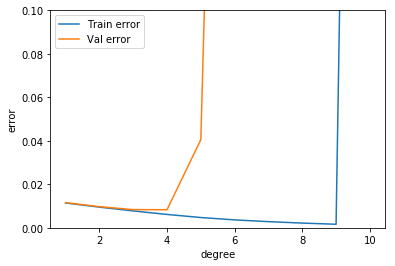

In [141]:
degree_range=list(range(1,11))
train_num=5
epoch   =100
multiprocess = 'OFF'
cpu_num=4
beta=0

# Calculate the beta array
t_start=time.time()
degree_array, error_train_poly, error_cv_poly=hf.train_loop(tcv, train_num, epoch, degree_range, other_v=beta, 
                                n_v='degree', rep=True, multiprocess=multiprocess, cpu_num=cpu_num, show=True)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The parameters are:\n\tdegree = {degree_range}\n\tbeta = {beta}'+
      '\n\tepoch= {epoch}\n\tmultiprcess is {multiprocess}')

d_idx=error_cv_poly.argmin()
degree_best = degree_range[d_idx]
print(degree_array)
print('The value of degree should be ', degree_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# plot error vs. beta
plt.figure()
plt.plot(degree_range, error_train_poly, label = 'Train error')
plt.plot(degree_range, error_cv_poly, label = 'Val error')
plt.ylim((0,0.1))
plt.xlabel('degree')
plt.ylabel('error')
plt.legend()

### Example to find best regulation coefficient

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:02:54; Left: 00:00:00 (Total: 00:02:54)

The time cost is 00:02:54
The parameters are:
	beta_num = 5
	degree=4
	epoch = 100
	multiprcess is ON
The values of beta with various regulation coefficients and different training samples are:
[0.10368657 0.10368657 0.06799469 0.05506191 0.06799469]
The value of BETA should be  0.06799469086438518


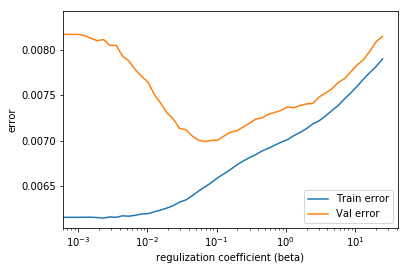

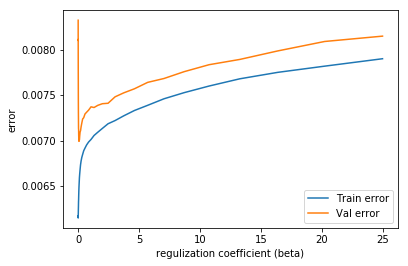

In [233]:
beta_range=np.geomspace(0.001,25, num = 50-1, endpoint = True, dtype=np.float64)
beta_range=np.insert(beta_range,0,0) # insert a zero element in the first index
beta_num=5
epoch   =100
multiprocess = 'ON'
cpu_num=4
degree =4

# Calculate the beta array, the other_v is degree
t_start=time.time()
beta_array, error_train_reg, error_cv_reg=hf.train_loop(tcv, beta_num, epoch, beta_range, other_v=degree, 
                            n_v='beta', rep=True, multiprocess=multiprocess, cpu_num=cpu_num)
t_end=time.time()
print(f'\nThe time cost is {hf.formatTime(t_end-t_start)}',end='\n')

print(f'The parameters are:\n\tbeta_num = {beta_num}\n\tdegree={degree}\n\tepoch = {epoch}\n\tmultiprcess is {multiprocess}')
print(f'The values of beta with various regulation coefficients and '+ 
      f'different training samples are:\n{beta_array}')

b_idx=error_cv_reg.argmin()
beta_best = beta_range[b_idx]
print('The value of BETA should be ', beta_best)
# print('The test error with best THETA and BETA is ', error_test_reg)

# log-scale plot error vs. beta
plt.figure()
plt.semilogx(beta_range, error_train_reg, label = 'Train error')
plt.semilogx(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

# plot error vs. beta
plt.figure()
plt.plot(beta_range, error_train_reg, label = 'Train error')
plt.plot(beta_range, error_cv_reg, label = 'Val error')
plt.xlabel('regulization coefficient (beta)')
plt.ylabel('error')
plt.legend()

### Theta training

Progress: |██████████████████████████████████████████████████| 100.00% Complete     Run: 00:00:46; Left: 00:00:00 (Total: 00:00:46)


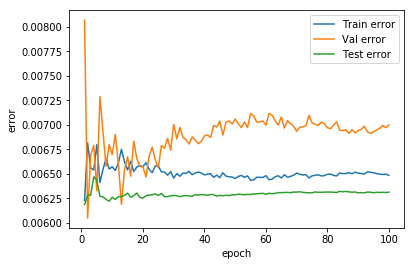

In [7]:
beta=0.06799469086438518
degree=4
epoch=100
test_data.polyFeature(degree)
featureSize=test_data.norm.shape[1]
multiprocess='OFF'
cpu_num=4
rep=True

theta_multismpl=np.zeros((epoch, featureSize))
error_train_theta=np.zeros(epoch)
error_cv_theta=np.zeros(epoch)
error_test_theta=np.zeros(epoch)
epoch_list=list(range(1,epoch+1))

total=epoch
pbar=progressBar(total, prefix = 'Progress:', suffix = 'Complete', decimals = 2, length = 50)
tm=timer(total)

for i in range(0,epoch):
    
    theta_multismpl, error_train_multismpl, error_cv_multismpl = hf.theta_multismpl(tcv, i+1, degree, beta, 
                                                        featureSize, rep, epoch*89+21*i, multiprocess, cpu_num)
    error_train_theta[i]=error_train_multismpl.mean(0)
    error_cv_theta[i]=error_cv_multismpl.mean(0)
    
    theta_test=theta_multismpl.mean(0)
    error_test_theta[i]=hf.computeCost(test_data.norm, test_J, theta_test)
                   
    # show the progess and timer    
    s1=pbar.update(i+1, ToPrint=False)
    s2=tm.update(i+1,ToPrint=False)
    print('\r'+s1+" "*5+s2,end='\r')
    if i+1==total:
        print()

# plot error vs. beta
plt.figure()
plt.plot(epoch_list, error_train_theta, label = 'Train error')
plt.plot(epoch_list, error_cv_theta, label = 'Val error')
plt.plot(epoch_list, error_test_theta, label = 'Test error')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()


# Prediction

0.006336337855353618
[[ 1.         -1.04888668 -0.66641464 ... -0.81120382 -0.37648305
  -0.31512162]
 [ 1.          0.14691987 -0.30581678 ... -0.28787569 -0.27670822
  -0.30552327]
 [ 1.          1.82104904 -0.48979528 ...  0.64173531 -0.26115615
  -0.31177857]
 ...
 [ 1.          1.53405547 -0.67377378 ... -0.04256867 -0.32787866
  -0.31521852]
 [ 1.          0.00342308 -0.13655656 ... -0.22354714 -0.23200006
  -0.29622788]
 [ 1.          0.05125534  0.01062624 ... -0.02739217 -0.16537589
  -0.28449231]]
[1.70849062e-03 2.73870768e-05 3.47772043e-02 ... 6.42268755e-05
 2.70762599e-06 1.87103337e-04]
[4.91606490e-77 5.77148951e-29 5.78894283e-03 ... 4.28843235e-13
 5.73575327e-26 1.10872284e-21]
(15,)


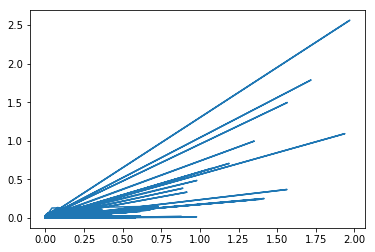

In [231]:
prd_J=np.power(test_data.norm @ theta_test.T-test_J,2)
print(np.sum(prd_J)/(2 * len(test_data.norm)))

plt.plot(test_J,prd_J)
print(test_data.norm)
print(prd_J)
print(test_J)
print(theta_test.shape)
